# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `dataproject.py` file includes a function which will be used multiple times in this notebook.

# Data Science Project - Group 5 (Goldman Grinders)

Data analysis with data from the Federal Reserve Bank of st. Louis.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import pandas_datareader 
import pydst 
import datetime
import math
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing tables from the FRED source, we have chosen $1$-Year Treasury Constant Maturity Rate (DGS1), $10$-Year Treasury Constant Maturity Rate (DGS10) and Wilshire 5000 Full Cap Price Index (Will5000prfc) where all the timeseries end in $25^{th}$ of March 2020. Note the different starttime, this will be corrected for in the code later.

In [64]:
# a. load

#Setting times:
start = datetime.datetime(1950,1,1)
end = datetime.datetime(2020,3,27)

#Loading data for stock index, two interest rates for rate spread:
stocks = pandas_datareader.data.DataReader('WILL5000PRFC','fred',start,end)
dgs1 = pandas_datareader.data.DataReader('dgs1','fred',start,end)
dgs10 = pandas_datareader.data.DataReader('dgs10','fred',start,end)

#Renaming stocks-column for easier retreival:
stocks.rename(columns={'WILL5000PRFC':'stocks'},inplace=True)

#Merging data into single dataframe:
mellemregning = pd.merge(stocks,dgs1,how='inner',left_index=True,right_index=True)
data = pd.merge(mellemregning,dgs10,how='inner',left_index=True,right_index=True)

#Deleting NaN:
data.dropna(inplace=True)

#Defining spread:
data['spread'] = data['dgs10']-data['dgs1']
data['logstocks'] = [
    math.log(i)
    for i in data['stocks']
]

data


,stocks,dgs1,dgs10,spread,logstocks
DATE,,,,,
1970-12-31,830.27,4.94,6.50,1.56,6.721751
1971-01-29,873.31,4.23,6.09,1.86,6.772291
1971-02-26,885.37,3.69,6.14,2.45,6.786006
1971-03-31,923.13,3.92,5.53,1.61,6.827770
1971-04-30,955.25,4.77,6.08,1.31,6.861973
...,...,...,...,...,...
2020-03-20,23082.46,0.15,0.92,0.77,10.046828
2020-03-23,22463.62,0.17,0.76,0.59,10.019652
2020-03-24,24542.52,0.25,0.84,0.59,10.108162


In [67]:
#Creating moving averages:
data['stocks_mvavg'] = data['logstocks'].rolling(window=1000).mean(center=True)
data['dgs10_mvavg'] = data['dgs10'].rolling(window=1000).mean(center=True)

TypeError: _apply() got multiple values for keyword argument 'center'

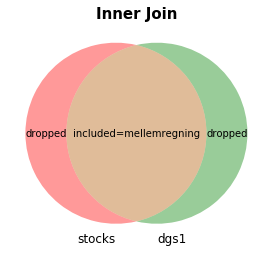

In [68]:
#Plotting a venn-digram of the merging method for "mellemregning"
plt.figure()
v = venn2(subsets = (4, 4, 10), set_labels = ('stocks', 'dgs1'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped')
v.get_label_by_id('110').set_text('included=mellemregning')
plt.title('Inner Join', weight='bold',fontsize=15)
plt.show()

In the follwoing code extract summary statistics of the merged dataset, due to the many observations we have fx calculated the yearly growth on the long interest rate to describe the dataset and further we will estimate the covariance-matrix to analyse the relation between the short interest rate and the SP&500. 

In [69]:
#Take a copy of the merged dataset
growth_data=data.copy()
#add calculated variable 'growth'
growth_data['growth']=growth_data['dgs10'].pct_change(periods=365,fill_method='ffill',freq='D')
#delete empty values
growth_data.dropna(inplace=True)
#show data
growth_data



,stocks,dgs1,dgs10,spread,logstocks,growth
DATE,,,,,,
1971-12-31,949.26,4.46,5.89,1.43,6.855683,-0.093846
1972-03-30,1013.10,5.11,6.12,1.01,6.920770,0.106691
1972-09-29,1028.17,5.61,6.54,0.93,6.935536,0.090000
1973-02-28,1010.11,6.43,6.64,0.21,6.917815,0.099338
1973-03-30,1001.61,7.09,6.73,-0.36,6.909364,0.099673
...,...,...,...,...,...,...
2020-03-19,24064.36,0.20,1.12,0.92,10.088487,-0.559055
2020-03-20,23082.46,0.15,0.92,0.77,10.046828,-0.637795
2020-03-24,24542.52,0.25,0.84,0.59,10.108162,-0.654321


In the following code we calculate the covariance matrix, that describes how two variables co-vary:

In [70]:
#Estimating covariance-matrix between stocks and 1-year Treasury yield
Covariance=np.cov(data['stocks'],y=data['dgs1'])
print(Covariance)

[[ 6.25248551e+07 -2.09711608e+04]
 [-2.09711608e+04  1.44749799e+01]]


We note that the diagonal is the variance of stocks and the 1-year Treasury Yield, respectively. The opposite diagonal represents the covariance between the variables, thus we conclude a negative correlation. This indicates that the two variables move inversely and thereby illustrates the substituion-effect between the two, which is coherent with economic theory. 

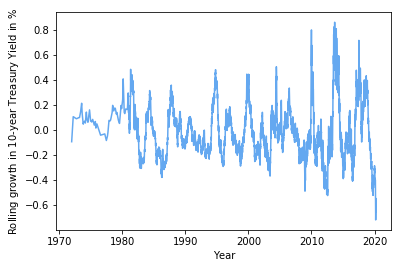

In [74]:
#plotting the growth rate
plt.plot(growth_data['growth'], c='#64a8f0')
plt.ylabel('Rolling growth in 10-year Treasury Yield in $\%$ ', fontsize=10)
plt.xlabel('Year',fontsize=10)
plt.show()

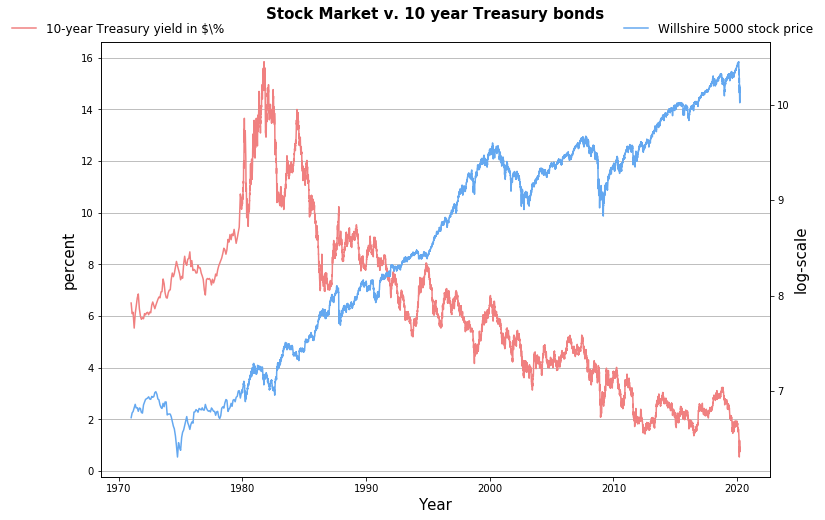

In [72]:
#Plotting:
fig, ax1 = plt.subplots(figsize=(12,8))
plt.title('Stock Market v. 10 year Treasury bonds',fontsize=15,weight='bold',pad=23)
plt.xlabel('Year',fontsize=15)

ax1.plot(data['dgs10'], label='10-year Treasury yield in $\%',c='lightcoral')
#ax1.plot(data['dgs10_mvavg'],c='maroon',linestyle='--',label='__no_legend__')
ax1.grid(axis='y')
plt.ylabel('percent',fontsize=15)
plt.legend(frameon=False,bbox_to_anchor=(0.2,1.07),fontsize=12)

ax2 = ax1.twinx()
goldman_blue = '#64a8f0'
ax2.plot(data['logstocks'], label='Willshire 5000 stock price',c=goldman_blue)
#ax2.plot(data['stocks_mvavg'],c='navy',linestyle='--',label='__no_legend__')
plt.ylabel('log-scale',fontsize=15)
plt.legend(frameon=False,bbox_to_anchor=(1.08,1.07),fontsize=12)


# Regression analysis

In [9]:
#Defining regression model::
import statsmodels.api as sm

X = sm.add_constant(data['dgs10'])
model = sm.OLS(data['logstocks'],X)
results = model.fit()
results.params
print(results.summary())
print(np.std(data['logstocks']))

OLS Regression Results                            
Dep. Variable:              logstocks   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 5.610e+04
Date:                Mon, 30 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:30:23   Log-Likelihood:                -4470.2
No. Observations:               10176   AIC:                             8944.
Df Residuals:                   10174   BIC:                             8959.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4443      0.008   1350.179      0.000      10.429      10.460
d

In the following code we perform a regression with OLS. Note that we have chosen the $10$-year maturity rate, since this will represent the most realistic trading trade-off. Our model is: 
$$log(stocks_i)=\beta_0+\beta_1dgs10_i$$

Where $stocks_i$ is the Willshire5000 stock index closing price for a given day i, and $dgs10_i$ denotes the yield of 10-year Treasury Bonds for day i.

Thus, we interpret the $\beta_1$-parameter as the percentage change in stock prices resulted from an increase in the Treasury yield by 1 percentage point

We conclude that the dgs10 parameter affects the $10$-year maturity rate significantly negative, thus when the maturity rate increases with $1 \%$-point the stocks are estimated to decrease with $26\%$